# 1.Cookie Cats and Project Goal

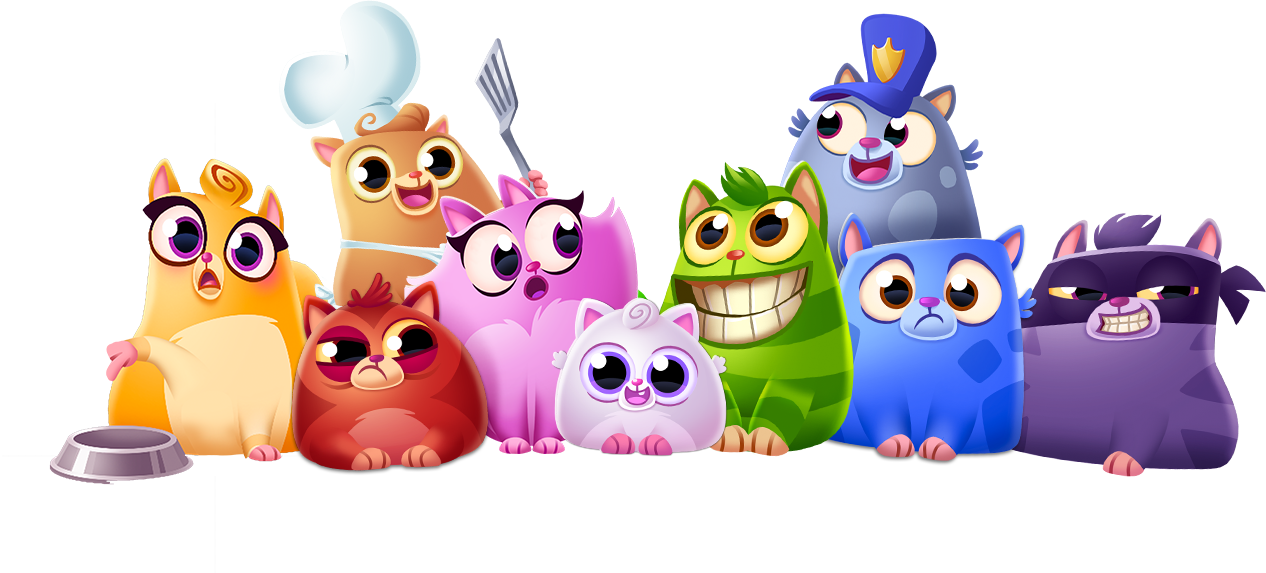

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data.

In [37]:
#import the dataset and take a look at first 5 rows.
import pandas as pd
df = pd.read_csv('cookie_cats.csv')
df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [38]:
df.shape

(90189, 5)

There are 90,189 players that installed the game while the AB-test was running.

The players were randomly assigned to either gate_30 or gate_40. Let's check if there are roughly same number of players in each group.

In [39]:
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

## The distribution of game rounds

Let's plot the distribution of the number of game rounds players played during their first week playing the game.

Text(0, 0.5, 'User Count')

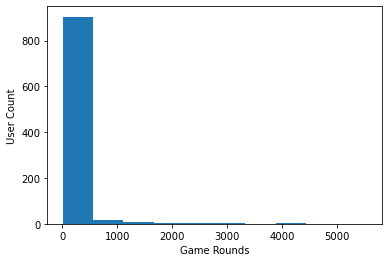

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

ax = plot_df.plot(x = 'sum_gamerounds', y = 'userid', kind = 'hist')
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

## Overall 1-day retention

A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

As a first step, let's look at what 1-day retention is overall.

In [17]:
# The % of users that came back the day after they installed
df['retention_1'].sum()/ df['retention_1'].count()

0.4452095044850259

## 1-day retention by AB-group

So, a little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.

In [48]:
# Calculating 1-day retention for each AB-group

df.groupby('version')['retention_1'].sum()/df.groupby('version')['retention_1'].count()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

<AxesSubplot:ylabel='Density'>

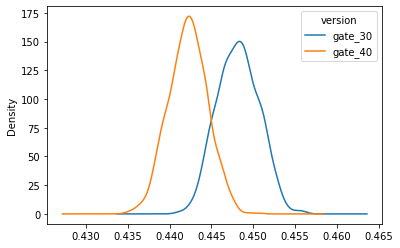

In [51]:
# Creating a list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot.kde()

Text(0.5, 0, '% difference in means')

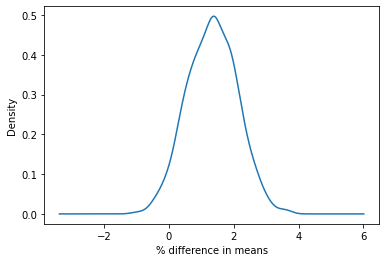

In [53]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_30']*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'kde')
# ... YOUR CODE FOR TASK 7 ...
ax.set_xlabel('% difference in means')

From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? Let's calculate that as well.

In [32]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).sum()/len(boot_1d)

# Pretty printing the probability
# ... YOUR CODE FOR TASK 8 ...
'{:.1%}'.format(prob)

'96.4%'

The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

Let's start by calculating 7-day retention for the two AB-groups.

## 7-day retention by AB-group

In [33]:
# Calculating 7-day retention for both AB-groups
# ... YOUR CODE FOR TASK 9 ...
df.groupby('version')['retention_7'].sum()/df.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.

'99.8%'

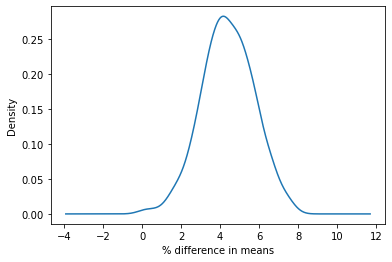

In [54]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
# ... YOUR CODE FOR TASK 10 ...
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_30'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum()/len(boot_7d)

# Pretty printing the probability
# ... YOUR CODE FOR TASK 10 ...
'{:.1%}'.format(prob)

## Conclusion

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.

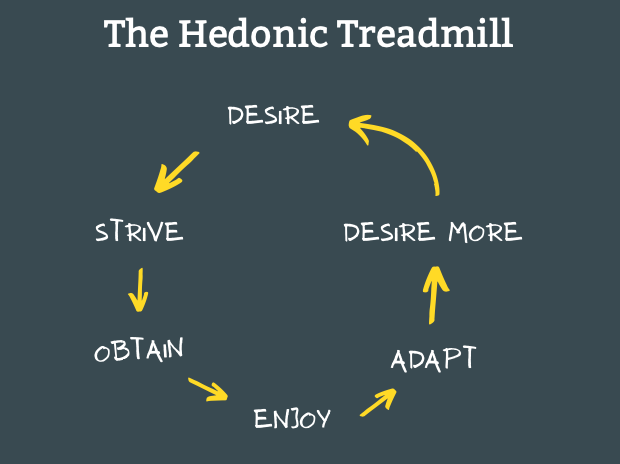

So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of hedonic adaptation can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.